# Darknet Detection
> PASCAL VOC2007

In [ ]:
from minai import *

import torch
import torch.nn as nn
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import  MulticlassAccuracy
import torchvision.transforms.v2.functional as TF

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

In [ ]:
from IPython.display import display, Image
from minai import *
import fastcore.all as fc
from fastcore.utils import L
from pilus_project.core import *
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchvision.transforms import v2

## Data 

In [ ]:
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#4) [Path('/home/galopy/data/VOCdevkit'),Path('/home/galopy/data/tiny-imagenet-200.zip'),Path('/home/galopy/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/galopy/data/tiny-imagenet-200')]

In [ ]:
ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=True)
ds

Using downloaded and verified file: /home/galopy/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/galopy/data/VOCtrainval_06-Nov-2007.tar to /home/galopy/data


Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/galopy/data

In [ ]:
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

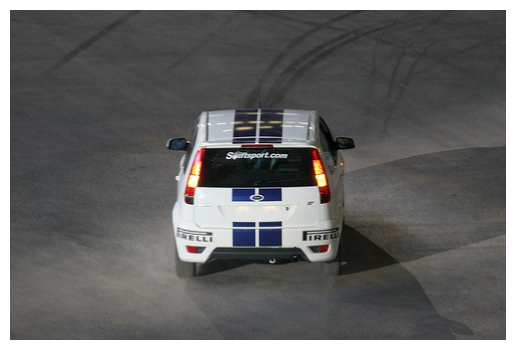

In [ ]:
show_image(ds[0][0]);

In [ ]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_files = list(Path(image_dir).glob('*.nd2'))
        self.transform = transform
        
    def __len__(self): return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = get_im(img_path)
        label_path = img_path.with_suffix('.csv')
        corners = calc_corners(str(label_path))
        
        if self.transform:
            img = self.transform(img)
            
        return img, corners

In [ ]:
class VOCDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', image_set='train', year='2007'):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transforms.Compose([
            transforms.Resize((416, 416)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = self.transform(img)
        
        # Extract bounding boxes and classes
        boxes = []
        classes = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            # Convert to [x1, y1, x2, y2]
            box = [
                float(bbox['xmin']), float(bbox['ymin']),
                float(bbox['xmax']), float(bbox['ymax'])
            ]
            boxes.append(box)
            classes.append(VOC_CLASSES.index(obj['name']))
            
        return img, {'boxes': torch.tensor(boxes), 'labels': torch.tensor(classes)}

In [ ]:
# 1. Create detection model
class YOLODetector(nn.Module):
    def __init__(self, num_classes=20, num_anchors=5):
        super().__init__()
        self.backbone = get_darknet19()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        # Detection head
        self.detector = nn.Sequential(
            ConvBlock(1024, 1024),
            nn.Conv2d(1024, num_anchors * (5 + num_classes), kernel_size=1)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.detector(x)
        
    def get_boxes(self, output, anchors, conf_threshold=0.5):
        # Process network output to get boxes
        batch_size, _, grid_size, _ = output.shape
        output = output.view(batch_size, self.num_anchors, 5 + self.num_classes, grid_size, grid_size)
        output = output.permute(0, 1, 3, 4, 2).contiguous()
        
        # Apply sigmoid to xy, objectness and class scores
        output[..., 0:2] = torch.sigmoid(output[..., 0:2])  # xy
        output[..., 4:] = torch.sigmoid(output[..., 4:])    # objectness + classes
        
        # Process predictions
        boxes = []
        for i in range(batch_size):
            # Get boxes with objectness > threshold
            pred = output[i]
            mask = pred[..., 4] > conf_threshold
            pred = pred[mask]
            
            if len(pred) == 0:
                boxes.append([])
                continue
                
            # Convert predictions to boxes [x, y, w, h, obj, class_id, class_prob]
            box_pred = pred[..., :5].clone()
            class_pred = pred[..., 5:]
            
            # Get class with highest probability
            class_scores, class_ids = torch.max(class_pred, dim=1)
            box_pred = torch.cat([box_pred, class_ids.float().unsqueeze(1), class_scores.unsqueeze(1)], dim=1)
            
            # Convert to [x1, y1, x2, y2, obj, class_id, class_prob]
            boxes.append(box_pred)
            
        return boxes

# 2. Custom dataset for bounding boxes
class VOCDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', image_set='train', year='2007'):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transforms.Compose([
            transforms.Resize((416, 416)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = self.transform(img)
        
        # Extract bounding boxes and classes
        boxes = []
        classes = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            # Convert to [x1, y1, x2, y2]
            box = [
                float(bbox['xmin']), float(bbox['ymin']),
                float(bbox['xmax']), float(bbox['ymax'])
            ]
            boxes.append(box)
            classes.append(VOC_CLASSES.index(obj['name']))
            
        return img, {'boxes': torch.tensor(boxes), 'labels': torch.tensor(classes)}